## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

In this assignment, you would be working with SMS data that contains SPAM or HAM messages. When you take a look at your gmail account, you find that a few emails are classified as spam. Similarly, some text messages that are received on the phone are also classified as spam based on a set of characteristics such as wording and so on. 

Therefore, we are going to address this problem of detecting SPAM or HAM messages with the help of Naive Bayes algorithm.

## Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv('spam.csv', sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [3]:
df.head()  # print head of data frame with help of head function

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
## Renaming the columns so that we understand the columns easily.

## Rename v1 as "spam_or_ham" and v2 as "message"

df = df.rename(columns = {'v1': 'spam_or_ham', 'v2': 'message'})

In [5]:
df.head()  # print head of data frame with help of head function 

,spam_or_ham,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Count plot of the output categories: spam or ham

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

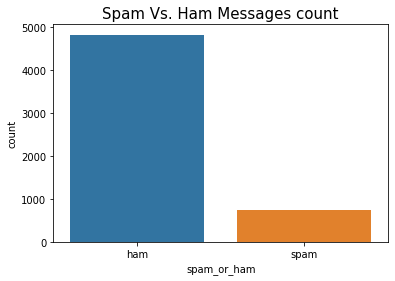

In [6]:
plt.figure(figsize = None)
sns.countplot(df['spam_or_ham'])
plt.title("Spam Vs. Ham Messages count", fontsize = 15)
plt.show()

## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is quite imbalanced. Therefore, class balancing must be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [7]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['spam_or_ham'] == 'ham']
df_minority = df[df['spam_or_ham'] == 'spam']

spam_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, spam_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [8]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "spam" as class label
df_upsampled[df_upsampled['spam_or_ham'] == 'spam'].shape

(4825, 2)

### Expected Output : 
(4825, 2)

In [9]:
## Ensure that the same number of data points are present for both 'spam' and 'ham' data

# print the shape of data set with the help of shape function having "ham" as class label
df_upsampled[df_upsampled['spam_or_ham'] == 'ham'].shape

(4825, 2)

### Expected Output : 
(4825, 2)

In [10]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 3000 spam and 3000 ham data points
spam_data_points_train = df_upsampled[df_upsampled['spam_or_ham'] == 'spam'].iloc[:3000]
ham_data_points_train = df_upsampled[df_upsampled['spam_or_ham'] == 'ham'].iloc[:3000]

## Considering the remaining data points for test
spam_data_points_test = df_upsampled[df_upsampled['spam_or_ham'] == 'spam'].iloc[3000:]
ham_data_points_test = df_upsampled[df_upsampled['spam_or_ham'] == 'ham'].iloc[3000:]

## Concatenate the training ham and spam messages
X_train = pd.concat([ham_data_points_train['message'], spam_data_points_train['message']])
## Concatenating the training ham and spam outputs
y_train = pd.concat([ham_data_points_train['spam_or_ham'], spam_data_points_train['spam_or_ham']])

## Concatenating the test ham and spam messages
X_test = pd.concat([ham_data_points_test['message'], spam_data_points_test['message']])
## Concatenating the test ham and spam outputs
y_test = pd.concat([ham_data_points_test['spam_or_ham'], spam_data_points_test['spam_or_ham']])


In [11]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of spam and ham messages. 
y_train.value_counts()

ham     3000
spam    3000
Name: spam_or_ham, dtype: int64

### Expected Output:
spam    3000<br>
ham     3000<br>
Name: spam_or_ham, dtype: int64

In [12]:
y_test.value_counts()

ham     1825
spam    1825
Name: spam_or_ham, dtype: int64

### Expected Output : 
spam    1825<br>
ham     1825<br>
Name: spam_or_ham, dtype: int64


## Pre-process the messages: (15 points)

We know that a message contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [13]:
# TASK CELL
import string
def clean_message(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        messages_cleaned: a list of words containing the processed message. 

    '''
    message = re.sub(r'https?://\S+', '', message)
    message_punc_removed = message.translate(str.maketrans('', '', string.punctuation))
    messages_tokenized = word_tokenize(message_punc_removed)
    messages_stemmed = [PorterStemmer().stem(word) for word in messages_tokenized]
    messages_cleaned = [word for word in messages_stemmed if word not in stopwords.words('english')]

    return messages_cleaned

## Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [14]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    n = frequency.get((word, label), 0)
    return n

## Converting output to numerical format:

We have outputs as 'ham' or 'spam'. In the cell below, we convert it to a numerical format. 

In [15]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'ham': 0, 'spam': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [16]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

0    3000
1    3000
Name: spam_or_ham, dtype: int64

In [17]:
## Choosing a random message and taking a look at it.
X_train.iloc[0]

'Jos ask if u wana meet up?'

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [18]:
custom_message = X_train.iloc[0]

# print cleaned message
print(clean_message(custom_message))

['jo', 'ask', 'u', 'wana', 'meet']


We now use this function to pre-process the message and remove words that don't add a lot of meaning in our model. 

## Implementing message counter function: (10 points)

It is now time to implement the count function for the messages. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'spam'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'ham'.



In [19]:
# TASK CELL
def message_counter(output_occurrence, messages, spam_or_ham):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        messages: a list of messages
        spam_or_ham: a list corresponding to the sentiment of each message (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, message in zip(spam_or_ham, messages):
        for word in clean_message(message):
            
            output_occurrence[(word, label)] = find_occurrence(output_occurrence, word, label) + 1

    return output_occurrence


## Test your function with example messages:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [20]:
# Testing your function

result = {}
messages = ['get offer upto 20%', 'I am coming now', 'Click on the link', 'get a latest car', 'canvas class scheduled']
ys = [1, 0, 1, 1, 0]
message_counter(result,messages, ys)

{('get', 1): 2,
 ('offer', 1): 1,
 ('upto', 1): 1,
 ('20', 1): 1,
 ('come', 0): 1,
 ('click', 1): 1,
 ('link', 1): 1,
 ('latest', 1): 1,
 ('car', 1): 1,
 ('canva', 0): 1,
 ('class', 0): 1,
 ('schedul', 0): 1}

### Expected Output:
{('get', 1): 2, <br>
 ('offer', 1): 1, <br>
 ('upto', 1): 1, <br>
 ('20', 1): 1, <br>
 ('i', 0): 1, <br>
 ('come', 0): 1, <br>
 ('click', 1): 1, <br>
 ('link', 1): 1, <br>
 ('latest', 1): 1, <br>
 ('car', 1): 1, <br>
 ('canva', 0): 1, <br>
 ('class', 0): 1, <br>
 ('schedul', 0): 1}

In [21]:
# Build the freqs dictionary for later uses

freqs = message_counter({}, X_train, y_train)

In [22]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a message is 'spam'.
## Similarly, we also compute the frequence of occurence of word given that a message is 'ham'.
freqs

{('jo', 0): 3,
 ('ask', 0): 76,
 ('u', 0): 612,
 ('wana', 0): 9,
 ('meet', 0): 69,
 ('im', 0): 277,
 ('free', 0): 39,
 ('moment', 0): 7,
 ('dayha', 0): 1,
 ('valuemorn', 0): 1,
 ('bring', 0): 25,
 ('hopeafternoon', 0): 1,
 ('faitheven', 0): 1,
 ('luvnight', 0): 1,
 ('restwish', 0): 1,
 ('find', 0): 32,
 ('todaygood', 0): 1,
 ('morn', 0): 48,
 ('ye', 0): 46,
 ('start', 0): 29,
 ('send', 0): 73,
 ('request', 0): 5,
 ('make', 0): 81,
 ('pain', 0): 21,
 ('came', 0): 18,
 ('back', 0): 77,
 ('bed', 0): 20,
 ('doubl', 0): 2,
 ('coin', 0): 5,
 ('factori', 0): 1,
 ('got', 0): 165,
 ('ta', 0): 10,
 ('cash', 0): 6,
 ('nitro', 0): 1,
 ('night', 0): 70,
 ('ha', 0): 69,
 ('end', 0): 20,
 ('anoth', 0): 24,
 ('day', 0): 116,
 ('come', 0): 198,
 ('special', 0): 25,
 ('way', 0): 74,
 ('may', 0): 26,
 ('smile', 0): 51,
 ('like', 0): 143,
 ('sunni', 0): 6,
 ('ray', 0): 5,
 ('leav', 0): 58,
 ('worri', 0): 28,
 ('blue', 0): 11,
 ('bay', 0): 4,
 ('gud', 0): 32,
 ('mrng', 0): 8,
 ('havent', 0): 26,
 ('plan', 

## Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is spam. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [23]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of messages
        train_y: a list of labels correponding to the messages (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set()
    for key in freqs.keys():
        vocab.add(key[0])
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_x)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = train_y.value_counts()[1]

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = train_y.value_counts()[0]

    # Calculate logprior
    logprior = np.log(pos_num_docs) - np.log(neg_num_docs)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 1)
        freq_neg = find_occurrence(freqs, word, 0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/ (pos_num_docs + V)
        p_w_neg = (freq_neg + 1)/ (neg_num_docs + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)


    return logprior, loglikelihood

In [24]:

# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
6572


### Expected Output 

0.0 <br>
6763

## Implementing Naive Bayes Predict Function: (15 points)

It is now time to make our prediction as to whether a given message is spam or ham respectively. 

After adding the log likelihood values, ensure that the output is 1 (spam) if the sum of the log likelihood value is greater than 0 and 0 (ham) if the sum of the log likelihood is less than or equal to 0. 

In [25]:
# TASK 4 CELL

def naive_bayes_predict(message, logprior, loglikelihood):
    '''
    Params:
        message: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the message (if found in the dictionary) + logprior (a number)

    '''
    
     # process the message to get a list of words
    word_l = clean_message(message)

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob = logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood.keys():
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]


    return 1 if total_prob > 0 else 0

In [32]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own message.
my_message = 'here is an offer for you'
p = naive_bayes_predict(my_message, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 0

## Implementing Naive Bayes Test function: (15 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of messages that it correctly classified as 'spam' or 'ham'. 

In [27]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of messages
        test_y: the corresponding labels for the list of messages
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of messages classified correctly)/(total # of message)
    """
    accuracy = 0  

    
    y_hats = []
    for message in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(message, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = sum(1 for expected, real in zip(test_y, y_hats) if expected != real) / len(test_y)

    accuracy = 1 - error

    return accuracy

# test_naive_bayes(X_test, y_test, logprior, loglikelihood)

In [28]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function
for message in ['get an offer', 'get the latest movie review', 'order iphone', 'I am on a meeting']:
    # print( '%s -> %f' % (message, naive_bayes_predict(message, logprior, loglikelihood)))
    p = naive_bayes_predict(message, logprior, loglikelihood)
#     print(f'{message} -> {p:.2f} ({p_category})')
    print(f'{message} -> {p:.2f}')

get an offer -> 1.00
get the latest movie review -> 1.00
order iphone -> 1.00
I am on a meeting -> 0.00


### Expected Output :
get an offer -> 1.00 <br>
get the latest movie review -> 1.00 <br>
order iphone -> 1.00 <br>
I am on a meeting -> 0.00 <br>


In [29]:
# Feel free to check the sentiment of your own message below
my_message = 'get an offer of iphone 13 and grab your order'
naive_bayes_predict(my_message, logprior, loglikelihood)

1

### Expected Output :
1

## Theory Questions: (15 points)

1. When performing Naive Bayes operation especially for text classification, why is there a requirement for Laplace Smoothing or Additive Smoothing? Explain with considering an example of training and the test set and show how not having additive smoothing leads to undesirable outcomes. (10 points)  
Answer: The Laplace or Additive Smoothing would prevent the value of "probability of word" being zero, which will further prevent the error when computing the log likelihood. Let's say the word "language" occurs only in the training dataset with negative labels instead of the training dataset with the positive labels. Here comes a document "I like language processing.", since the word "language" in the training dataset are all with negative labels, then the probability that "language" is positive is 0. In the end, the log likelihood of the "language" could not be computed since the log(0) does not exist.

2. Why are logarithmic values computed for naive bayes algorithm rather than only the probability values? (5 points)  
Answer: The log function is monotonically increasing, which has the same order relation as the original likelihood. Moreover, the usage of log function would transform the multiply of likelihood function to summation of the log likelihood function as what I did to the total_prob in the naive_bayes_predict() function, which would avoid the underflow when many decimals are multiplied.